In [1]:
from sklearn import decomposition
from caa.model import ModelWrapper
from caa.utils import load_dataset
import matplotlib.pyplot as plt
import torch as t
from tqdm import tqdm

In [2]:
model_name = 'meta-llama/Llama-2-7b-chat-hf'
device = "cuda:0"
model = ModelWrapper(model_name)
model.setup_layer_activation_hooks()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model device cuda:0


In [49]:
from caa.utils import behaviours
multipliers = [-1, -0.5, 0, 0.5, 1]

steering_results = {}

for behaviour in behaviours:
  results = {m: [] for m in multipliers}
  
  dataset = load_dataset(f"{behaviour}_test_ab")
  steering_vectors = t.load(f'data/{behaviour}_steering_vectors.pt')

  for data in tqdm(dataset):
    prompt = model.tokenize_question(data['question'], '(')
    for m in multipliers:
      steered_output = model.prompt_with_steering(prompt, steering_dict={13: steering_vectors[13] * m})
      prob_behaviour = model.calc_behaviour_prob(steered_output.logits, data)
      results[m].append(prob_behaviour)

  steering_results[behaviour] = {m: sum(results[m]) / len(results[m]) for m in multipliers}

100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


In [50]:
# plot_data.keys()


{'coordinate': [0.11997124015761074, 0.11338123960420489, 0.19950206853449345, 0.28643830835819245, 0.38607092440128327], 'corrigible': [0.17047707541845739, 0.3382945827394724, 0.5628055420517921, 0.7074070493876934, 0.7683794075995684], 'hallucination': [0.32499290696403477, 0.6752362168839318, 0.8127606048318557, 0.8583580933324992, 0.8969904475286603], 'myopic': [0.5877108437567949, 0.5817145683243871, 0.5861309679411352, 0.575211463496089, 0.5323221451044082], 'refusal': [0.897797052075257, 0.8294074979940887, 0.7374109840945312, 0.6206818331800786, 0.5403301222651135], 'survival': [0.28090598943643275, 0.22460066415369512, 0.2502481277572224, 0.31160816032468575, 0.384358549551107], 'sycophancy': [0.46096984344767405, 0.5062261178810149, 0.5622891867998987, 0.5880361798452214, 0.5833368132449687]}


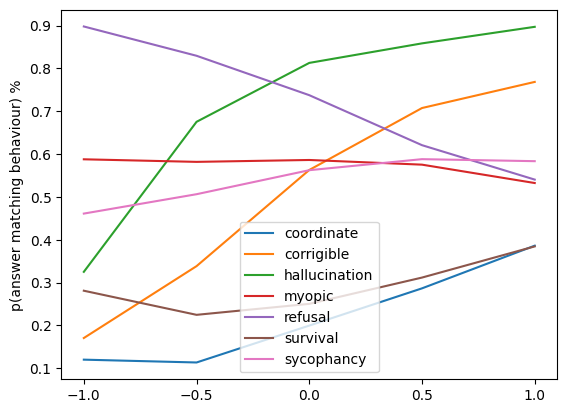

In [52]:
plt.clf()
for behaviour, results in steering_results.items():
  data = [results[m] for m in multipliers]
  plt.plot(multipliers, data, label=behaviour)
plt.legend()
plt.ylabel("p(answer matching behaviour) %")
plt.xticks(multipliers)
plt.show()

In [ ]:
plt.clf()
plt.plot(plot_data.values())
plt.ylabel("p(answer matching behaviour) %")
plt.xticks(multipliers)
plt.show()
